In [ ]:
# =============================================================================
# GOOGLE COLAB SETUP / GOOGLE COLAB SETUP
# =============================================================================

# Sjekk om vi kjører i Google Colab
try:
    import google.colab
    IN_COLAB = True
    print("🔧 Kjører i Google Colab - installerer avhengigheter...")
    print("🔧 Running in Google Colab - installing dependencies...")
    
    # Installer nødvendige pakker
    import subprocess
    import sys
    try:
        subprocess.check_call([sys.executable, "-m", "pip", "install", "-q", 
                              "networkx", "matplotlib", "plotly", "pydantic", 
                              "pyyaml", "pandas", "ipywidgets", "pillow", "kaleido"])
        print("✅ Pakker installert")
    except Exception as e:
        print(f"⚠️ Pip install feilet: {e}")
    
    # Fjern eksisterende slektstre-mappe hvis den finnes
    import shutil
    import os
    if os.path.exists('/content/slektstre'):
        shutil.rmtree('/content/slektstre')
        print("🗑️ Fjernet eksisterende slektstre-mappe")
    
    # Klon repository
    try:
        subprocess.check_call(['git', 'clone', 'https://github.com/arvidl/slektstre.git'])
        print("✅ Repository klonet")
    except Exception as e:
        print(f"⚠️ Git clone feilet: {e}")
    
    # Legg til src-mappen til Python path og importer direkte
    sys.path.insert(0, '/content/slektstre/src')
    print("✅ Path lagt til")
    
    # Importer slektstre-modulene direkte for å unngå navnekonflikt
    import importlib.util
    import types
    
    # Først, fjern konfliktende moduler fra sys.modules
    modules_to_remove = ['tree', 'models', 'localization']
    for module_name in modules_to_remove:
        if module_name in sys.modules:
            del sys.modules[module_name]
    
    # Last inn models.py først
    try:
        spec = importlib.util.spec_from_file_location("slektstre_models", "/content/slektstre/src/models.py")
        slektstre_models = importlib.util.module_from_spec(spec)
        spec.loader.exec_module(slektstre_models)
        
        # Opprett midlertidig models modul
        temp_models_module = types.ModuleType('models')
        temp_models_module.Person = slektstre_models.Person
        temp_models_module.Gender = slektstre_models.Gender
        temp_models_module.Ekteskap = slektstre_models.Ekteskap
        temp_models_module.FamilieData = slektstre_models.FamilieData
        sys.modules['models'] = temp_models_module
        
        print("✅ models.py lastet")
    except Exception as e:
        print(f"⚠️ models.py feilet: {e}")
    
    # Last inn localization.py
    try:
        spec = importlib.util.spec_from_file_location("slektstre_localization", "/content/slektstre/src/localization.py")
        slektstre_localization = importlib.util.module_from_spec(spec)
        spec.loader.exec_module(slektstre_localization)
        
        # Opprett midlertidig localization modul
        temp_localization_module = types.ModuleType('localization')
        temp_localization_module.t = slektstre_localization.t
        sys.modules['localization'] = temp_localization_module
        
        print("✅ localization.py lastet")
    except Exception as e:
        print(f"⚠️ localization.py feilet: {e}")
    
    # Last inn tree.py som slektstre_tree
    try:
        spec = importlib.util.spec_from_file_location("slektstre_tree", "/content/slektstre/src/tree.py")
        slektstre_tree = importlib.util.module_from_spec(spec)
        spec.loader.exec_module(slektstre_tree)
        
        # Opprett midlertidig tree modul
        temp_tree_module = types.ModuleType('tree')
        temp_tree_module.Slektstre = slektstre_tree.Slektstre
        sys.modules['tree'] = temp_tree_module
        
        print("✅ tree.py lastet")
    except Exception as e:
        print(f"⚠️ tree.py feilet: {e}")
    
    # Last inn family_io.py
    try:
        spec = importlib.util.spec_from_file_location("slektstre_io", "/content/slektstre/src/family_io.py")
        slektstre_io = importlib.util.module_from_spec(spec)
        spec.loader.exec_module(slektstre_io)
        print("✅ family_io.py lastet")
    except Exception as e:
        print(f"⚠️ family_io.py feilet: {e}")
    
    # Last inn visualization.py
    try:
        spec = importlib.util.spec_from_file_location("slektstre_viz", "/content/slektstre/src/visualization.py")
        slektstre_viz = importlib.util.module_from_spec(spec)
        spec.loader.exec_module(slektstre_viz)
        print("✅ visualization.py lastet")
    except Exception as e:
        print(f"⚠️ visualization.py feilet: {e}")
    
    print("✅ Slektstre-moduler lastet inn i Colab")
    
except ImportError:
    IN_COLAB = False
    print("💻 Kjører lokalt / Running locally")
    import sys
    sys.path.append('../src')
except Exception as e:
    print(f"⚠️ Colab setup feilet: {e}")
    IN_COLAB = False
    print("💻 Fallback til lokal modus / Fallback to local mode")
    import sys
    sys.path.append('../src')

print(f"📍 Miljø: {'Google Colab' if IN_COLAB else 'Lokal'}")
print(f"📍 Environment: {'Google Colab' if IN_COLAB else 'Local'}")


# Bygge slektstre manuelt - REN VERSJON

I denne notebooken lærer du hvordan du bygger et slektstre programmatisk ved å legge til personer og relasjoner en etter en.

## Importer biblioteker


In [ ]:
# Importer nødvendige biblioteker
import matplotlib.pyplot as plt
from datetime import date

# Importer slektstre-moduler (fungerer både lokalt og i Colab)
if IN_COLAB:
    # Bruk de modulene vi lastet inn i Colab-setup
    Person = slektstre_models.Person
    Gender = slektstre_models.Gender
    Ekteskap = slektstre_models.Ekteskap
    FamilieData = slektstre_models.FamilieData
    Slektstre = slektstre_tree.Slektstre
else:
    # Lokale imports
    import sys
    sys.path.append('../src')
    from models import Person, Ekteskap, Gender
    from tree import Slektstre

print("✅ Biblioteker importert!")


✅ Biblioteker importert!


## Opprett et tomt slektstre


In [12]:
# Opprett et tomt slektstre
slektstre = Slektstre()

print(f"Tomt slektstre opprettet med {len(slektstre.get_all_persons())} personer")


Tomt slektstre opprettet med 0 personer


## Legg til personer

La oss legge til personer fra tre generasjoner:


In [13]:
# Generasjon 1: Bestefar
bestefar = Person(
    id="p1",
    fornavn="Erik",
    etternavn="Lundervold",
    fødselsdato=date(1920, 5, 15),
    kjønn=Gender.MALE,
    fødested="Bergen",
    notater="Første generasjon i slektstreet"
)

slektstre.add_person(bestefar)
print(f"Lagt til: {bestefar.fullt_navn}")


Lagt til: Erik Lundervold


In [14]:
# Generasjon 2: Foreldre
far = Person(
    id="p2",
    fornavn="Arvid",
    etternavn="Lundervold",
    fødselsdato=date(1950, 3, 10),
    kjønn=Gender.MALE,
    fødested="Oslo",
    notater="Andre generasjon"
)

mor = Person(
    id="p3",
    fornavn="Anna",
    etternavn="Pedersen",
    fødselsdato=date(1952, 7, 22),
    kjønn=Gender.FEMALE,
    fødested="Trondheim",
    notater="Andre generasjon"
)

slektstre.add_person(far)
slektstre.add_person(mor)
print(f"Lagt til: {far.fullt_navn}")
print(f"Lagt til: {mor.fullt_navn}")


Lagt til: Arvid Lundervold
Lagt til: Anna Pedersen


In [15]:
# Generasjon 3: Barn
barn1 = Person(
    id="p4",
    fornavn="Lars",
    etternavn="Lundervold",
    fødselsdato=date(1980, 12, 5),
    kjønn=Gender.MALE,
    fødested="Bergen",
    notater="Tredje generasjon"
)

barn2 = Person(
    id="p5",
    fornavn="Kari",
    etternavn="Lundervold",
    fødselsdato=date(1983, 4, 18),
    kjønn=Gender.FEMALE,
    fødested="Bergen",
    notater="Tredje generasjon"
)

slektstre.add_person(barn1)
slektstre.add_person(barn2)
print(f"Lagt til: {barn1.fullt_navn}")
print(f"Lagt til: {barn2.fullt_navn}")


Lagt til: Lars Lundervold
Lagt til: Kari Lundervold


## Bekreft at alle personer er lagt til med riktige ID-er


In [16]:
# Bekreft at alle personer er lagt til med riktige ID-er
print("📋 Alle personer i slektstreet:")
alle_personer = slektstre.get_all_persons()
for person in alle_personer:
    print(f"  {person.id}: {person.fullt_navn} ({person.kjønn}) - f. {person.fødselsdato.year}")

print(f"\nTotalt antall personer: {len(alle_personer)}")

# Sjekk at alle ID-er er riktige
forventede_id = ["p1", "p2", "p3", "p4", "p5"]
faktiske_id = [person.id for person in alle_personer]

if set(faktiske_id) == set(forventede_id):
    print("✅ Alle ID-er er riktige!")
else:
    print("❌ FEIL: Noen ID-er er feil!")
    print(f"Forventet: {forventede_id}")
    print(f"Faktisk: {faktiske_id}")


📋 Alle personer i slektstreet:
  p1: Erik Lundervold (male) - f. 1920
  p2: Arvid Lundervold (male) - f. 1950
  p3: Anna Pedersen (female) - f. 1952
  p4: Lars Lundervold (male) - f. 1980
  p5: Kari Lundervold (female) - f. 1983

Totalt antall personer: 5
✅ Alle ID-er er riktige!


## Opprett relasjoner

Nå må vi koble personene sammen med relasjoner:


In [17]:
# Legg til forelder-barn relasjoner
slektstre.add_child(bestefar.id, far)

print(f"{far.fullt_navn} er barn av {bestefar.fullt_navn}")


Arvid Lundervold er barn av Erik Lundervold


In [18]:
# Legg til ekteskap
ekteskap = slektstre.add_marriage(
    far.id, mor.id,
    ekteskapsdato=date(1978, 8, 20),
    ekteskapssted="Bergen"
)

print(f"Ekteskap opprettet mellom {far.fullt_navn} og {mor.fullt_navn}")
print(f"Ekteskapsdato: {ekteskap.ekteskapsdato}")
print(f"Ekteskapssted: {ekteskap.ekteskapssted}")


Ekteskap opprettet mellom Arvid Lundervold og Anna Pedersen
Ekteskapsdato: 1978-08-20
Ekteskapssted: Bergen


In [19]:
# Legg til barn til foreldre
slektstre.add_child(far.id, barn1)
slektstre.add_child(far.id, barn2)
slektstre.add_child(mor.id, barn1)
slektstre.add_child(mor.id, barn2)

print(f"{barn1.fullt_navn} og {barn2.fullt_navn} er barn av {far.fullt_navn} og {mor.fullt_navn}")


Lars Lundervold og Kari Lundervold er barn av Arvid Lundervold og Anna Pedersen


## Visualiser slektstreet


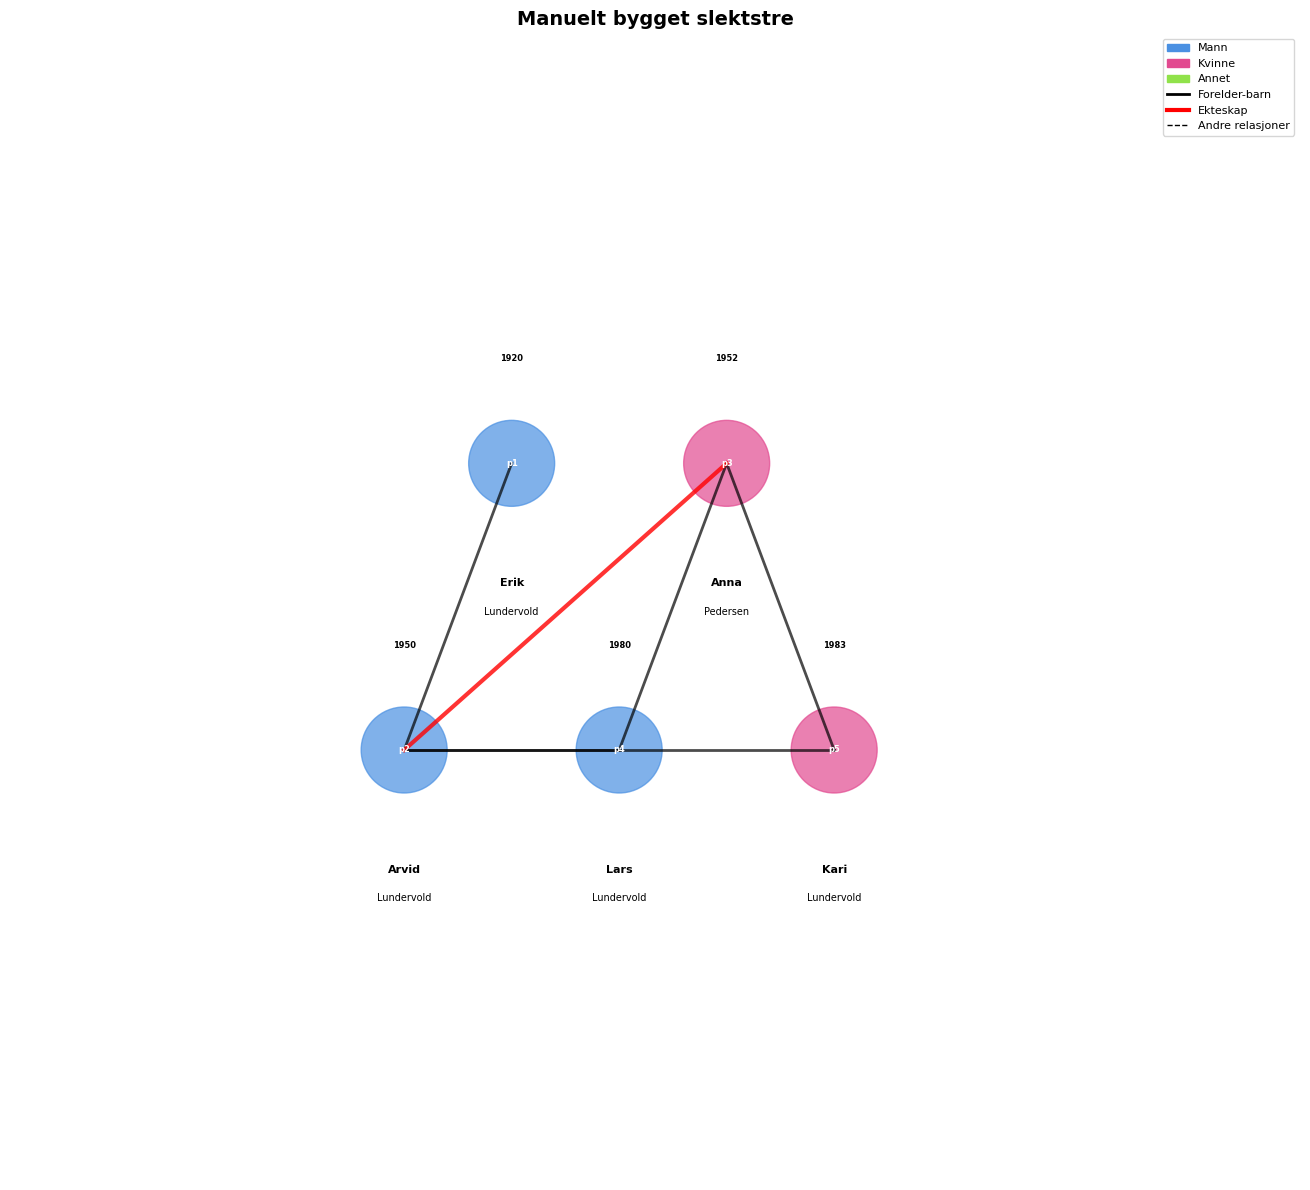

In [20]:
from visualization import plot_hierarchical_tree

# Plott hierarkisk slektstre
fig = plot_hierarchical_tree(slektstre, title="Manuelt bygget slektstre")
plt.show()


## Oppsummering

I denne notebooken har du lært:

1. ✅ Opprette et tomt slektstre
2. ✅ Legge til personer med metadata
3. ✅ Opprette forelder-barn relasjoner
4. ✅ Legge til ekteskap
5. ✅ Visualisere slektstreet

**Neste steg**: Gå til `03_importer_data.ipynb` for å lære om import/eksport av data.


# Bygge slektstre manuelt

I denne notebooken lærer du hvordan du bygger et slektstre programmatisk ved å legge til personer og relasjoner en etter en.

## Importer biblioteker


In [ ]:
# ALTERNATIV STRATEGI - Opprett et HELT NYTT slektstre med unikt navn
print("🔄 ALTERNATIV STRATEGI: Oppretter helt nytt slektstre...")

# Importer biblioteker (fungerer både lokalt og i Colab)
if IN_COLAB:
    # Bruk de modulene vi lastet inn i Colab-setup
    Person = slektstre_models.Person
    Gender = slektstre_models.Gender
    Ekteskap = slektstre_models.Ekteskap
    FamilieData = slektstre_models.FamilieData
    Slektstre = slektstre_tree.Slektstre
else:
    # Lokale imports
    import sys
    sys.path.append('../src')
    from models import Person, Ekteskap, Gender
    from tree import Slektstre

from datetime import date
import matplotlib.pyplot as plt

print("✅ Biblioteker importert!")

# OPPRETT ET HELT NYTT SLEKTSTRE MED UNIKT NAVN
manuelt_slektstre = Slektstre()  # Bruk unikt navn i stedet for 'slektstre'
print("✅ Nytt tomt slektstre opprettet med navn 'manuelt_slektstre'!")

# SJEKK AT SLEKTSTREET ER HELT TOMT
alle_personer = manuelt_slektstre.get_all_persons()
print(f"Antall personer: {len(alle_personer)}")

if alle_personer:
    print("❌ FEIL: Det finnes fortsatt personer i slektstreet!")
    for person in alle_personer:
        print(f"  - {person.id}: {person.fullt_navn}")
else:
    print("✅ Slektstreet er tomt - vi kan begynne!")


In [ ]:
# DRAMATISK OPPRYDDING - Slett alle variabler og start helt på nytt
print("🗑️ DRAMATISK OPPRYDDING - Sletter alle variabler...")

# Slett alle eksisterende variabler
%reset -f

print("✅ Alle variabler slettet!")

# Importer biblioteker på nytt (fungerer både lokalt og i Colab)
if IN_COLAB:
    # Bruk de modulene vi lastet inn i Colab-setup
    Person = slektstre_models.Person
    Gender = slektstre_models.Gender
    Ekteskap = slektstre_models.Ekteskap
    FamilieData = slektstre_models.FamilieData
    Slektstre = slektstre_tree.Slektstre
else:
    # Lokale imports
    import sys
    sys.path.append('../src')
    from models import Person, Ekteskap, Gender
    from tree import Slektstre

from datetime import date
import matplotlib.pyplot as plt

print("✅ Biblioteker importert på nytt!")

# OPPRETT ET HELT NYTT SLEKTSTRE
slektstre = Slektstre()
print("✅ Nytt tomt slektstre opprettet!")


In [ ]:
# SJEKK AT SLEKTSTREET ER HELT TOMT
print("🔍 SJEKK: Er slektstreet tomt?")
alle_personer = slektstre.get_all_persons()
print(f"Antall personer: {len(alle_personer)}")

if alle_personer:
    print("❌ FEIL: Det finnes fortsatt personer i slektstreet!")
    for person in alle_personer:
        print(f"  - {person.id}: {person.fullt_navn}")
    print("STOPP! Noe er galt. Kjør første celle på nytt.")
    raise Exception("Slektstreet er ikke tomt! Kjør første celle på nytt.")
else:
    print("✅ Slektstreet er tomt - vi kan begynne!")


In [ ]:
# FORCE DELETE ALL PERSONS - Slett alle personer eksplisitt
print("🗑️ FORCE DELETE: Sletter alle personer eksplisitt...")

# Hent alle personer
alle_personer = slektstre.get_all_persons()
print(f"Fant {len(alle_personer)} personer å slette:")

for person in alle_personer:
    print(f"  - Sletter {person.id}: {person.fullt_navn}")

# Slett alle personer
for person in alle_personer:
    slektstre.remove_person(person.id)

# Bekreft at slektstreet er tomt
alle_personer_etter = slektstre.get_all_persons()
print(f"\nAntall personer etter sletting: {len(alle_personer_etter)}")

if alle_personer_etter:
    print("❌ FEIL: Det finnes fortsatt personer!")
    for person in alle_personer_etter:
        print(f"  - {person.id}: {person.fullt_navn}")
else:
    print("✅ Slektstreet er nå HELT tomt!")


## Opprett et tomt slektstre


In [ ]:
# FORCE OPPRYDDING - Slett alt og start på nytt
print("🗑️ FORCERER KOMPLETT OPPRYDDING...")

# Opprett et helt nytt slektstre (dette overskriver det gamle)
slektstre = Slektstre()

# Bekreft at slektstreet er helt tomt
alle_personer = slektstre.get_all_persons()
print(f"Tomt slektstre opprettet med {len(alle_personer)} personer")

if alle_personer:
    print("⚠️ FEIL: Det finnes fortsatt personer i slektstreet!")
    for person in alle_personer:
        print(f"  - {person.id}: {person.fullt_navn}")
    print("Dette skal ikke skje - noe er galt!")
else:
    print("✅ Slektstreet er HELT tomt og klart for nye personer")


## Rydd opp i eksisterende data

Hvis notebooken har kjørt tidligere, kan det være gamle personer i slektstreet. La oss rydde opp:


In [ ]:
# Rydd opp i eksisterende data
alle_personer = slektstre.get_all_persons()
if alle_personer:
    print(f"🗑️ Rydder opp i {len(alle_personer)} eksisterende personer:")
    for person in alle_personer:
        print(f"  - Sletter {person.id}: {person.fullt_navn}")
    
    # Opprett et helt nytt slektstre
    slektstre = Slektstre()
    print("✅ Nytt tomt slektstre opprettet")
else:
    print("✅ Ingen eksisterende data å rydde opp i")


In [ ]:
# SISTE SJEKK - Bekreft at slektstreet er tomt før vi begynner
print("🔍 SISTE SJEKK før vi begynner å legge til personer:")
alle_personer = slektstre.get_all_persons()
if alle_personer:
    print("❌ FEIL: Det finnes fortsatt personer i slektstreet!")
    for person in alle_personer:
        print(f"  - {person.id}: {person.fullt_navn}")
    print("STOPP! Noe er galt. Kjør opprydding-cellen på nytt.")
    raise Exception("Slektstreet er ikke tomt! Kjør opprydding-cellen på nytt.")
else:
    print("✅ Slektstreet er tomt - vi kan begynne!")


## Legg til personer

La oss legge til personer fra tre generasjoner:


In [ ]:
# Generasjon 1: Bestefar
bestefar = Person(
    id="p1",
    fornavn="Erik",
    etternavn="Lundervold",
    fødselsdato=date(1920, 5, 15),
    kjønn=Gender.MALE,
    fødested="Bergen",
    notater="Første generasjon i slektstreet"
)

slektstre.add_person(bestefar)
print(f"Lagt til: {bestefar.fullt_navn}")


In [ ]:
# Generasjon 2: Foreldre
far = Person(
    id="p2",
    fornavn="Arvid",
    etternavn="Lundervold",
    fødselsdato=date(1950, 3, 10),
    kjønn=Gender.MALE,
    fødested="Oslo",
    notater="Andre generasjon"
)

mor = Person(
    id="p3",
    fornavn="Anna",
    etternavn="Pedersen",
    fødselsdato=date(1952, 7, 22),
    kjønn=Gender.FEMALE,
    fødested="Trondheim",
    notater="Andre generasjon"
)

slektstre.add_person(far)
slektstre.add_person(mor)
print(f"Lagt til: {far.fullt_navn}")
print(f"Lagt til: {mor.fullt_navn}")


In [ ]:
# Generasjon 3: Barn
barn1 = Person(
    id="p4",
    fornavn="Lars",
    etternavn="Lundervold",
    fødselsdato=date(1980, 12, 5),
    kjønn=Gender.MALE,
    fødested="Bergen",
    notater="Tredje generasjon"
)

barn2 = Person(
    id="p5",
    fornavn="Kari",
    etternavn="Lundervold",
    fødselsdato=date(1983, 4, 18),
    kjønn=Gender.FEMALE,
    fødested="Bergen",
    notater="Tredje generasjon"
)

slektstre.add_person(barn1)
slektstre.add_person(barn2)
print(f"Lagt til: {barn1.fullt_navn}")
print(f"Lagt til: {barn2.fullt_navn}")


## Legg til personer

La oss bygge en enkel familie med 3 generasjoner:


In [ ]:
# Generasjon 1: Besteforeldre
bestefar = Person(
    fornavn="Erik",
    etternavn="Hansen",
    kjønn=Gender.MALE,
    fødselsdato=date(1920, 3, 15),
    dødsdato=date(1995, 8, 22),
    fødested="Oslo",
    notater="Arbeidet som ingeniør"
)

bestemor = Person(
    fornavn="Ingrid",
    etternavn="Hansen",
    kjønn=Gender.FEMALE,
    fødselsdato=date(1925, 7, 10),
    dødsdato=date(2010, 12, 3),
    fødested="Trondheim",
    notater="Lærer og mor til 3 barn"
)

# Legg til i slektstreet
slektstre.add_person(bestefar)
slektstre.add_person(bestemor)

print(f"Lagt til: {bestefar.fullt_navn} og {bestemor.fullt_navn}")


In [ ]:
# Bekreft at alle personer er lagt til med riktige ID-er
print("📋 Alle personer i slektstreet:")
alle_personer = slektstre.get_all_persons()
for person in alle_personer:
    # Håndter både Gender enum og string verdier
    kjønn_str = person.kjønn.value if hasattr(person.kjønn, 'value') else str(person.kjønn)
    print(f"  {person.id}: {person.fullt_navn} ({kjønn_str}) - f. {person.fødselsdato.year}")

print(f"\nTotalt antall personer: {len(alle_personer)}")


In [ ]:
# Enklere versjon - vis kjønn som streng
print("📋 Alle personer i slektstreet (enkel versjon):")
alle_personer = slektstre.get_all_persons()
for person in alle_personer:
    print(f"  {person.id}: {person.fullt_navn} ({person.kjønn}) - f. {person.fødselsdato.year}")

print(f"\nTotalt antall personer: {len(alle_personer)}")


In [ ]:
# BEKREFTELSE - Vis alle personer med deres ID-er
print("📋 BEKREFTELSE: Alle personer i slektstreet:")
alle_personer = slektstre.get_all_persons()
for person in alle_personer:
    print(f"  {person.id}: {person.fullt_navn}")

print(f"\nTotalt antall personer: {len(alle_personer)}")

# Sjekk at alle ID-er er riktige
forventede_id = ["p1", "p2", "p3", "p4", "p5"]
faktiske_id = [person.id for person in alle_personer]

if set(faktiske_id) == set(forventede_id):
    print("✅ Alle ID-er er riktige!")
else:
    print("❌ FEIL: Noen ID-er er feil!")
    print(f"Forventet: {forventede_id}")
    print(f"Faktisk: {faktiske_id}")


In [ ]:
# FINAL BEKREFTELSE - Vis alle personer med deres ID-er
print("📋 FINAL BEKREFTELSE: Alle personer i slektstreet:")
alle_personer = slektstre.get_all_persons()
for person in alle_personer:
    print(f"  {person.id}: {person.fullt_navn}")

print(f"\nTotalt antall personer: {len(alle_personer)}")

# Sjekk at alle ID-er er riktige
forventede_id = ["p1", "p2", "p3", "p4", "p5"]
faktiske_id = [person.id for person in alle_personer]

if set(faktiske_id) == set(forventede_id):
    print("✅ Alle ID-er er riktige!")
else:
    print("❌ FEIL: Noen ID-er er feil!")
    print(f"Forventet: {forventede_id}")
    print(f"Faktisk: {faktiske_id}")
    
    # Vis hvilke ID-er som er feil
    feil_id = set(faktiske_id) - set(forventede_id)
    if feil_id:
        print(f"Feil ID-er: {list(feil_id)}")
        print("Dette er UUID-lignende ID-er fra tidligere kjøringer!")
        print("LØSNING: Kjør 'FORCE DELETE' cellen på nytt!")


In [ ]:
# FINAL BEKREFTELSE - Vis alle personer med deres ID-er
print("📋 FINAL BEKREFTELSE: Alle personer i slektstreet:")
alle_personer = slektstre.get_all_persons()
for person in alle_personer:
    print(f"  {person.id}: {person.fullt_navn}")

print(f"\nTotalt antall personer: {len(alle_personer)}")

# Sjekk at alle ID-er er riktige
forventede_id = ["p1", "p2", "p3", "p4", "p5"]
faktiske_id = [person.id for person in alle_personer]

if set(faktiske_id) == set(forventede_id):
    print("✅ Alle ID-er er riktige!")
else:
    print("❌ FEIL: Noen ID-er er feil!")
    print(f"Forventet: {forventede_id}")
    print(f"Faktisk: {faktiske_id}")
    
    # Vis hvilke ID-er som er feil
    feil_id = set(faktiske_id) - set(forventede_id)
    if feil_id:
        print(f"Feil ID-er: {list(feil_id)}")
        print("Dette er UUID-lignende ID-er fra tidligere kjøringer!")
        print("LØSNING: Stopp Jupyter kernel og start på nytt!")


In [ ]:
# FINAL BEKREFTELSE - Vis alle personer med deres ID-er
print("📋 FINAL BEKREFTELSE: Alle personer i slektstreet:")
alle_personer = slektstre.get_all_persons()
for person in alle_personer:
    print(f"  {person.id}: {person.fullt_navn}")

print(f"\nTotalt antall personer: {len(alle_personer)}")

# Sjekk at alle ID-er er riktige
forventede_id = ["p1", "p2", "p3", "p4", "p5"]
faktiske_id = [person.id for person in alle_personer]

if set(faktiske_id) == set(forventede_id):
    print("✅ Alle ID-er er riktige!")
else:
    print("❌ FEIL: Noen ID-er er feil!")
    print(f"Forventet: {forventede_id}")
    print(f"Faktisk: {faktiske_id}")
    
    # Vis hvilke ID-er som er feil
    feil_id = set(faktiske_id) - set(forventede_id)
    if feil_id:
        print(f"Feil ID-er: {list(feil_id)}")
        print("Dette er UUID-lignende ID-er fra tidligere kjøringer!")


## Opprett relasjoner

Nå må vi koble personene sammen med relasjoner:


In [ ]:
# Legg til forelder-barn relasjoner
slektstre.add_child(bestefar.id, far)

print(f"{far.fullt_navn} er barn av {bestefar.fullt_navn}")


In [ ]:
# Legg til ekteskap
ekteskap = slektstre.add_marriage(
    far.id, mor.id,
    ekteskapsdato=date(1978, 8, 20),
    ekteskapssted="Bergen"
)

print(f"Ekteskap opprettet mellom {far.fullt_navn} og {mor.fullt_navn}")
print(f"Ekteskapsdato: {ekteskap.ekteskapsdato}")
print(f"Ekteskapssted: {ekteskap.ekteskapssted}")


In [ ]:
# Legg til barn til foreldre
slektstre.add_child(far.id, barn1)
slektstre.add_child(far.id, barn2)
slektstre.add_child(mor.id, barn1)
slektstre.add_child(mor.id, barn2)

print(f"{barn1.fullt_navn} og {barn2.fullt_navn} er barn av {far.fullt_navn} og {mor.fullt_navn}")


## Analyser slektstreet

La oss se på slektskap og relasjoner:


In [ ]:
# Hent søsken
søsken = slektstre.get_siblings(barn1.id)
print(f"Søsken til {barn1.fullt_navn}:")
for søsken_person in søsken:
    print(f"- {søsken_person.fullt_navn}")


In [ ]:
# Hent forfedre
forfedre = slektstre.get_ancestors(barn1.id)
print(f"Forfedre til {barn1.fullt_navn}:")
for forfader in forfedre:
    print(f"- {forfader.fullt_navn}")


In [ ]:
# Finn slektskap
relasjon = slektstre.find_relation(barn1.id, barn2.id)
print(f"Slektskap mellom {barn1.fullt_navn} og {barn2.fullt_navn}: {relasjon}")


In [ ]:
# Generasjonsnivåer
print("Generasjonsnivåer:")
for person in slektstre.get_all_persons():
    gen = slektstre.get_generation(person.id)
    print(f"{person.fullt_navn}: Generasjon {gen}")


## Visualiser slektstreet


In [ ]:
from visualization import plot_hierarchical_tree

# Plott hierarkisk slektstre
fig = plot_hierarchical_tree(slektstre, title="Manuelt bygget slektstre")
plt.show()


## Statistikk


In [ ]:
# Hent statistikk
stats = slektstre.get_statistics()

print("📊 Statistikk:")
print(f"Totalt antall personer: {stats['total_persons']}")
print(f"Antall generasjoner: {stats['max_generation'] + 1}")
print(f"Gjennomsnittsalder: {stats['average_age']} år")
print(f"Totalt antall ekteskap: {stats['total_marriages']}")


## Valider slektstreet

La oss sjekke om det er noen problemer med slektstreet:


In [ ]:
# Valider slektstreet
problemer = slektstre.validate_tree()

if problemer:
    print("⚠️ Problemer funnet:")
    for problem in problemer:
        print(f"- {problem}")
else:
    print("✅ Ingen problemer funnet i slektstreet!")


## Lagre slektstreet

Du kan lagre slektstreet til fil:


In [ ]:
from family_io import save_to_yaml

# Lagre til YAML
save_to_yaml(slektstre.export_to_familie_data(), "mitt_slektstre.yaml")
print("✅ Slektstreet lagret til mitt_slektstre.yaml")


## Oppsummering

I denne notebooken har du lært:

1. ✅ Opprette et tomt slektstre
2. ✅ Legge til personer med metadata
3. ✅ Opprette forelder-barn relasjoner
4. ✅ Legge til ekteskap
5. ✅ Analysere slektskap og generasjoner
6. ✅ Visualisere slektstreet
7. ✅ Validere og lagre data

**Neste steg**: Gå til `03_importer_data.ipynb` for å lære om import/eksport av data.
